In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy as scp
from scipy import optimize
from scipy import special
from scipy import stats
from scipy.stats import invgauss, pareto
from itertools import product
import xarray 
import warnings
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import os
import seaborn as sns
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from scipy.interpolate import interp1d
import simpy
import random as rand
import statistics as stat
from PIL import Image
from msmbuilder.lumping import PCCAPlus
from msmbuilder.msm import MarkovStateModel
from msmbuilder.cluster import KCenters, MiniBatchKMeans, MiniBatchKMedoids
from msmbuilder.msm.core import _solve_msm_eigensystem
from scipy.interpolate import griddata

fsize = 12.5
tsize = 12
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
# plt.style.use('default')
plt.style.use('seaborn-colorblind')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.markersize'] = 6
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle
plt.rc("savefig", dpi=600)
plt.rcParams['axes.titley'] = 1.0
titles = ["(a)","(b)","(c)","(d)","(e)","(f)"]

warnings.filterwarnings('ignore')

np.random.seed(45235)

imprting


Here, I study a model system of a particle diffusing in an asymmetric 3D potential. It is a double-well with a high barrier along the x-axis. Each well is in itself an asymmetric double-well with a smalle barrier along either the y- or z-axis, such that there are 4 stable states. Here are the integrated FES along the different coordinates. 

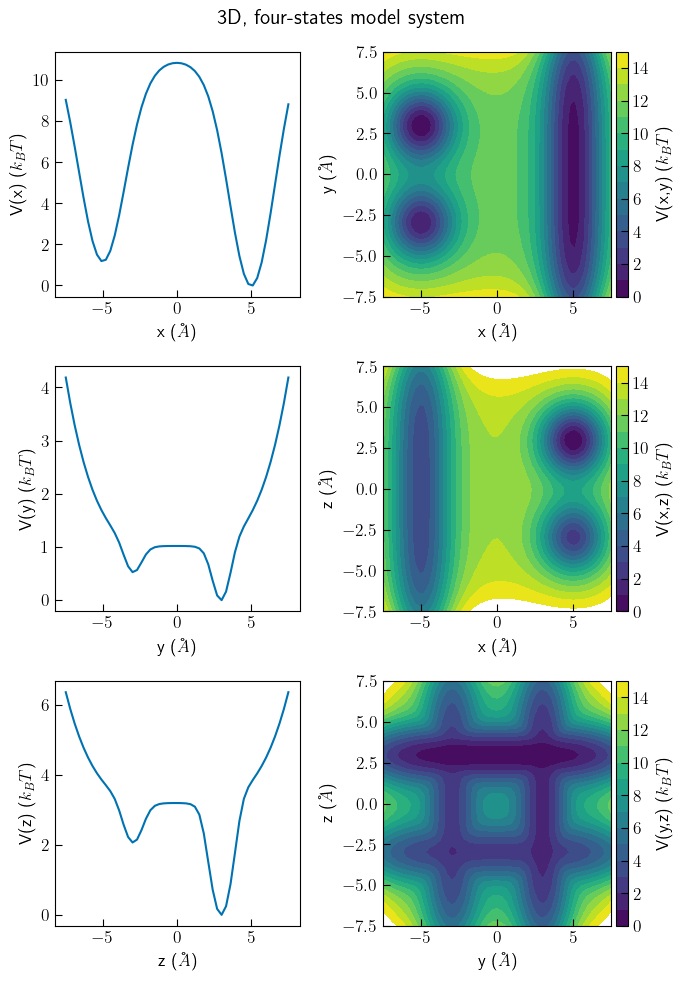

In [2]:
xs = []
ys = []
zs = []
Vs = []
for x in np.linspace(-7.5,7.5,51):
    for y in np.linspace(-7.5,7.5,51):
        for z in np.linspace(-7.5,7.5,51):
            xs.append(x)
            ys.append(y)
            zs.append(z)
            Vs.append(0.001*x**4-0.05*x**2+0.001*y**4+0.001*z**4 - 12.5*np.exp(-0.2*(z-3)**2-0.2*(x-5)**2)- 
                      10*np.exp(-0.2*(z+3)**2-0.2*(x-5)**2)- 11*np.exp(-0.2*(y-3)**2-0.2*(x+5)**2)- 
                      10*np.exp(-0.2*(y+3)**2-0.2*(x+5)**2))
surface = pd.DataFrame({"x":xs,"y":ys,"z":zs,"V":Vs})
surface.V -= surface.V.min() 
surface["H"] = np.exp(-surface.V)

fig, axs = plt.subplots(3,2,figsize=(7,10))
axs = axs.flatten()
surfacex = surface.groupby("x").sum("H").reset_index()
surfacex.H = surfacex.H/surfacex.H.sum()
surfacex.V = -np.log(surfacex.H)
surfacex.V -= surfacex.V.min()
axs[0].plot(surfacex.x,surfacex.V)
axs[0].set_xlabel(r"x ($\AA$)")
axs[0].set_ylabel(r"V(x) ($k_BT$)")

surfacey = surface.groupby("y").sum("H").reset_index()
surfacey.H = surfacey.H/surfacey.H.sum()
surfacey.V = -np.log(surfacey.H)
surfacey.V -= surfacey.V.min()
axs[2].plot(surfacey.y,surfacey.V)
axs[2].set_xlabel(r"y ($\AA$)")
axs[2].set_ylabel(r"V(y) ($k_BT$)")

surfacez = surface.groupby("z").sum("H").reset_index()
surfacez.H = surfacez.H/surfacez.H.sum()
surfacez.V = -np.log(surfacez.H)
surfacez.V -= surfacez.V.min()
axs[4].plot(surfacez.z,surfacez.V)
axs[4].set_xlabel(r"z ($\AA$)")
axs[4].set_ylabel(r"V(z) ($k_BT$)")

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
im = axs[1].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[1].set_xlabel(r"x ($\AA$)")
axs[1].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
im = axs[3].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,z) ($k_BT$)")
axs[3].set_xlabel(r"x ($\AA$)")
axs[3].set_ylabel(r"z ($\AA$)")

surface2 = surface.groupby(["z","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
im = axs[5].tricontourf(surface2.y,surface2.z,surface2.V,levels=np.linspace(0,15,16))
divider = make_axes_locatable(axs[5])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(y,z) ($k_BT$)")
axs[5].set_xlabel(r"y ($\AA$)")
axs[5].set_ylabel(r"z ($\AA$)")

fig.suptitle("3D, four-states model system")
fig.tight_layout()

I ran 5 unbiased trajectories of 1-5 microseconds and found 100 microstates using MiniBatchKMeans.

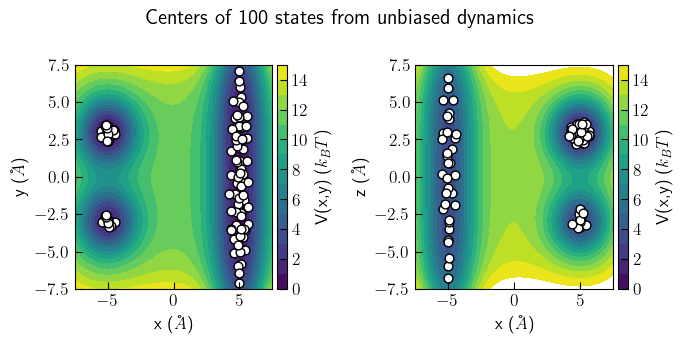

In [3]:
trajs = [np.loadtxt("XYZ",skiprows=1)[:,1:] * 10]
for i in range(2,6):
    trajs.append(np.loadtxt(f"{i}/XYZ",skiprows=1)[:,1:] * 10)
dim = 3
kmeans = MiniBatchKMeans(n_clusters=100)
kmeans.fit([traj[:, :dim] for traj in trajs])

fig, axs = plt.subplots(1,2,figsize=(7,3.5))

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
im = axs[0].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[0].scatter(kmeans.cluster_centers_[:, 0],
                    kmeans.cluster_centers_[:, 1],
                    s=40, color = "white", edgecolor="black")
axs[0].set_xlabel(r"x ($\AA$)")
axs[0].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
im = axs[1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[1].scatter(kmeans.cluster_centers_[:, 0],
           kmeans.cluster_centers_[:, 2],
           s=40, color = "white" ,edgecolor="black")

axs[1].set_xlabel(r"x ($\AA$)")
axs[1].set_ylabel(r"z ($\AA$)")

fig.suptitle("Centers of 100 states from unbiased dynamics")
fig.tight_layout()

Then, I plotted the 3 slowest timescales as a function of leg time and chose a lag time of 100 ps.

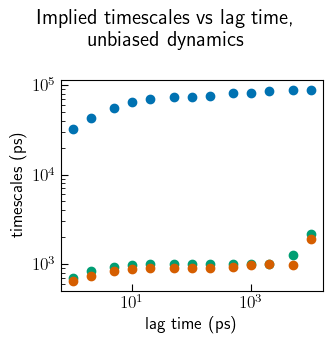

In [4]:
ktrajs = [kmeans.partial_transform(traj) for traj in trajs]
from msmbuilder.msm import MarkovStateModel

timescales = []
lagtimes = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000]
for lagtime in lagtimes:
    msm = MarkovStateModel(lag_time=lagtime, n_timescales=3, verbose=False)
    msm.fit(ktrajs)
    timescales.append(msm.timescales_)

fig, ax = plt.subplots(figsize=(3.5,3.5))

ax.plot(lagtimes,timescales,"o")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("lag time (ps)")
ax.set_ylabel("timescales (ps)")
fig.suptitle("Implied timescales vs lag time,\n unbiased dynamics")
fig.tight_layout()

The three slowest timescales found with this lag time are ~74, ~1, ~1 nanoseconds. Here are their corresponding eigenvectors.

Markov state model
------------------
Lag time         : 100
Reversible type  : mle
Ergodic cutoff   : on
Prior counts     : 0

Number of states : 100
Number of nonzero entries in counts matrix : 7145 (71.45%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.2
    Median : 1.3
    Mean   : 9.2
    3rd Qu.: 17.6
    Max.   : 48.1

Total transition counts :
    65967.65000000001 counts
Total transition counts / lag_time:
    659.6765 units
Timescales:
    [74065.19, 1013.89, 910.23]  units



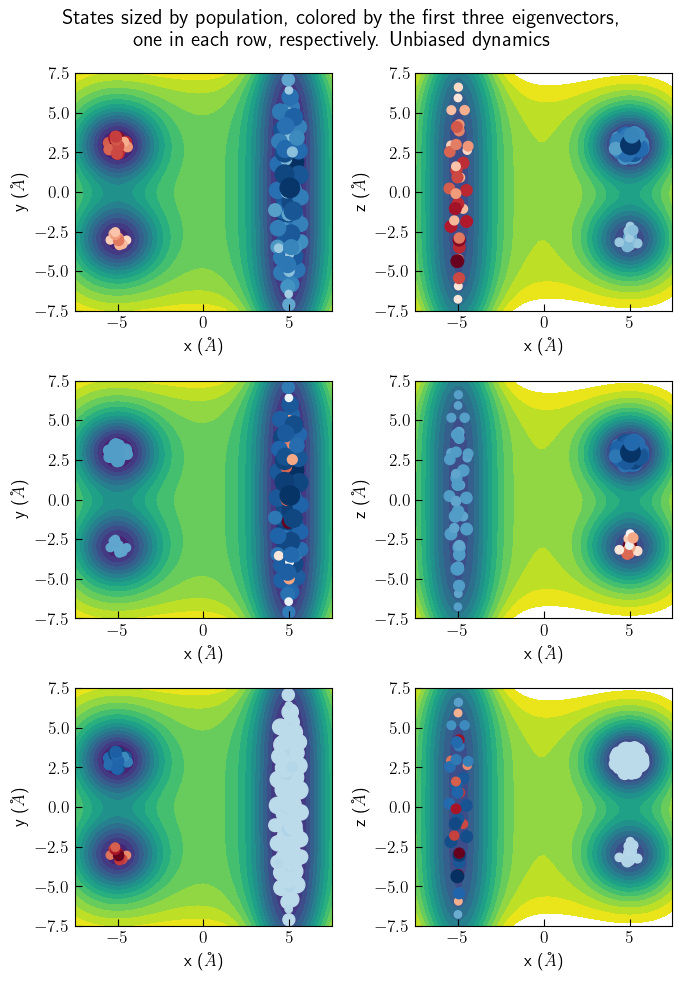

In [6]:
msm = MarkovStateModel(lag_time=100, n_timescales=3, verbose=False)
msm.fit(ktrajs)
scale = 200 / np.max(msm.populations_)
add_a_bit = 5

fig, axs = plt.subplots(3,2,figsize=(7,10))
axs = axs.flatten()

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2].set_xlabel(r"x ($\AA$)")
    axs[i*2].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2+1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2+1].set_xlabel(r"x ($\AA$)")
    axs[i*2+1].set_ylabel(r"z ($\AA$)")

for i in range(3):
    for j in range(2):
        axs[i*2+j].scatter(kmeans.cluster_centers_[msm.state_labels_, 0],
                           kmeans.cluster_centers_[msm.state_labels_, 1+j],
                           s=scale * msm.populations_ + add_a_bit,
                           c=msm.left_eigenvectors_[:, i+1],
                           cmap='RdBu')
fig.suptitle("States sized by population, colored by the first three eigenvectors,\n"\
              "one in each row, respectively. Unbiased dynamics")

fig.tight_layout()
print(msm.summarize())

As expected, the first eigenvector corresponds to transitions along the x-axis. The second and third are related to transitions along the y- and z- coordinates, respectively. Now I find 4 macrostates and construct a coarse-grained MSM.

Optimization terminated successfully.
         Current function value: -3.800659
         Iterations: 9
         Function evaluations: 98
Markov state model
------------------
Lag time         : 100
Reversible type  : mle
Ergodic cutoff   : on
Prior counts     : 0

Number of states : 4
Number of nonzero entries in counts matrix : 16 (100.0%)
Nonzero counts matrix entries:
    Min.   : 0.3
    1st Qu.: 3.8
    Median : 157.7
    Mean   : 4123.0
    3rd Qu.: 1271.9
    Max.   : 45004.6

Total transition counts :
    65967.65 counts
Total transition counts / lag_time:
    659.6764999999999 units
Timescales:
    [74057.30, 1013.79, 910.06]  units



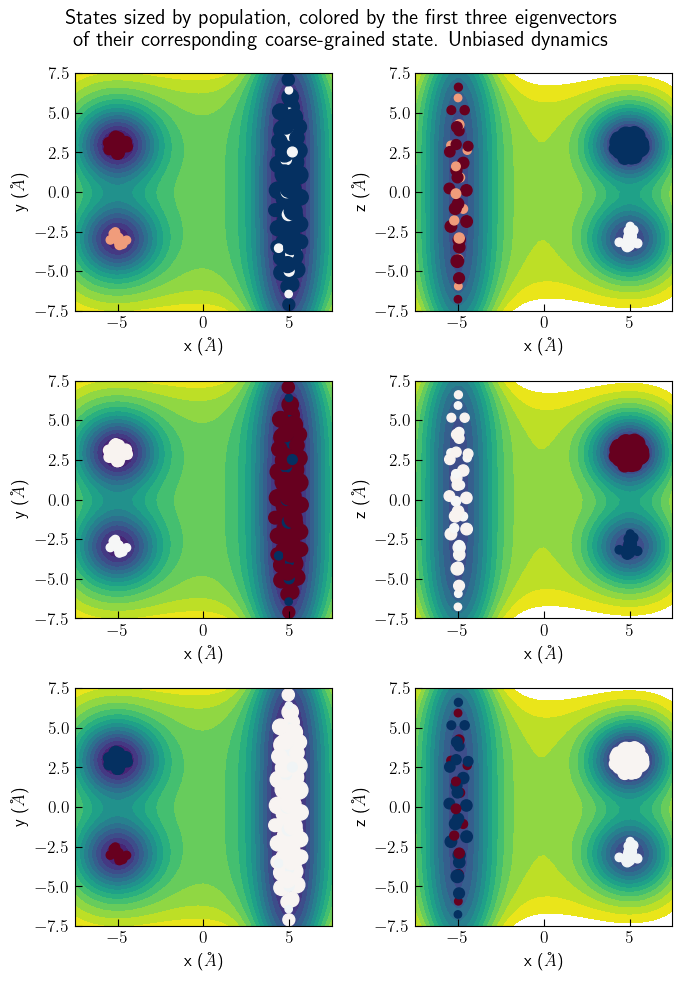

In [7]:
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(ktrajs)
CGmsm = MarkovStateModel(lag_time=100, n_timescales=3, verbose=False)
CGmsm.fit(macro_trajs)

fig, axs = plt.subplots(3,2,figsize=(7,10))
axs = axs.flatten()

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2].set_xlabel(r"x ($\AA$)")
    axs[i*2].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2+1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2+1].set_xlabel(r"x ($\AA$)")
    axs[i*2+1].set_ylabel(r"z ($\AA$)")

for i in range(3):
    for j in range(2):
        axs[i*2+j].scatter(kmeans.cluster_centers_[msm.state_labels_, 0],
                           kmeans.cluster_centers_[msm.state_labels_, 1+j],
                           s=scale * msm.populations_ + add_a_bit,
                           c=[CGmsm.left_eigenvectors_[:, i+1][k] for k in pcca.microstate_mapping_],
                           cmap='RdBu')
fig.suptitle("States sized by population, colored by the first three eigenvectors\n"\
              "of their corresponding coarse-grained state. Unbiased dynamics")
fig.tight_layout()
print(CGmsm.summarize())

Above, each microstate is colored according to the eigenvectors of its associated macrostate. The plot is consistent with the one of the microstates, and the timescales are almost identical.

In [106]:
print("Populations according to microstates: ", [sum(msm.populations_[pcca.microstate_mapping_== i]) for i in range(4)])
print("Populations according to macrostates: ", CGmsm.populations_)

Populations according to microstates:  [0.04776523599398287, 0.08184567470693774, 0.1307052825593659, 0.7396838067397132]
Populations according to macrostates:  [0.04776605 0.08184504 0.13070742 0.7396815 ]


The predicted equilibrium populations are also consistent.

I now turned to dynamics over a converged well-tempered MetaD bias with a biasfactor of 2. An MSM of the biased system is first built using a 50 ns trajectory, just for grasping the difference in timescales and equilibrium populations. I use a larger number of microstates and KCenters for the microstates' centers to have a more uniform coverage of phase space.

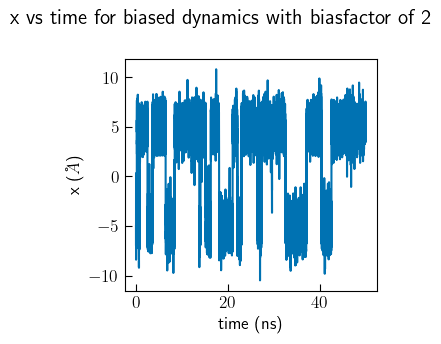

In [8]:
traj = np.loadtxt(f"biased2x/CVR",skiprows=1)
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax.plot(traj[:,0] / 1000, traj[:,1] * 10)
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"x ($\AA$)")
fig.suptitle("x vs time for biased dynamics with biasfactor of 2")
fig.tight_layout()

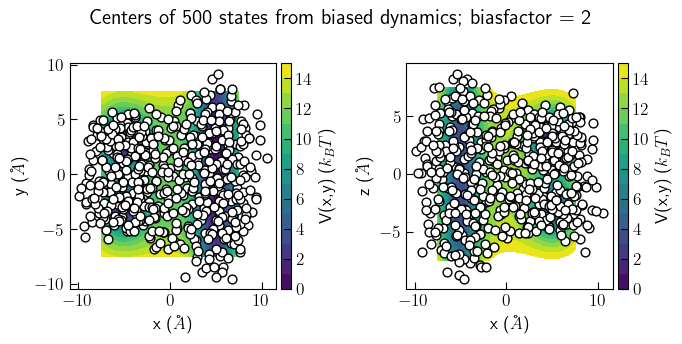

In [48]:
dim = 3 
np.random.seed(21349)
traj = np.loadtxt(f"biased2x/CVR",skiprows=1)[:,1:-1] * 10
size = 500
kmeans = KCenters(n_clusters=size)
kmeans.fit([traj[:, :dim]])

fig, axs = plt.subplots(1,2,figsize=(7,3.5))

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
im = axs[0].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[0].scatter(kmeans.cluster_centers_[:, 0],
                    kmeans.cluster_centers_[:, 1],
                    s=40, color = "white", edgecolor="black")
axs[0].set_xlabel(r"x ($\AA$)")
axs[0].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
im = axs[1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[1].scatter(kmeans.cluster_centers_[:, 0],
           kmeans.cluster_centers_[:, 2],
           s=40, color = "white" ,edgecolor="black")

axs[1].set_xlabel(r"x ($\AA$)")
axs[1].set_ylabel(r"z ($\AA$)")

fig.suptitle("Centers of 500 states from biased dynamics; biasfactor = 2")

fig.tight_layout()

1
2
5
10
20
50
100
200
500
1000
2000
5000
10000


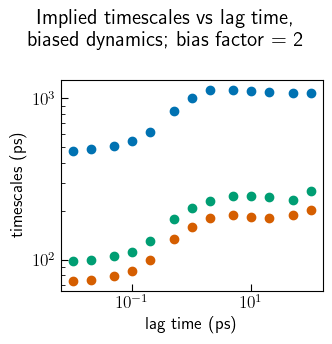

In [10]:
ktrajs = kmeans.predict([traj.copy()])
timescales = []
lagtimes = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000]
for lagtime in lagtimes:
    msm = MarkovStateModel(lag_time=lagtime, n_timescales=3, verbose=False)
    msm.fit(ktrajs)
    timescales.append(msm.timescales_/100)
    print(lagtime)

fig, ax = plt.subplots(figsize=(3.5,3.5))

ax.plot(np.array(lagtimes)/100,timescales,"o")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("lag time (ps)")
ax.set_ylabel("timescales (ps)")

fig.suptitle("Implied timescales vs lag time,\n biased dynamics; bias factor = 2")

fig.tight_layout()

Markov state model
------------------
Lag time         : 1000
Reversible type  : mle
Ergodic cutoff   : on
Prior counts     : 0

Number of states : 500
Number of nonzero entries in counts matrix : 16937 (6.7748%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.0
    Median : 0.0
    Mean   : 0.3
    3rd Qu.: 0.1
    Max.   : 56.8

Total transition counts :
    4999.001 counts
Total transition counts / lag_time:
    4.999001 units
Timescales:
    [111787.56, 24867.15, 18430.39]  units



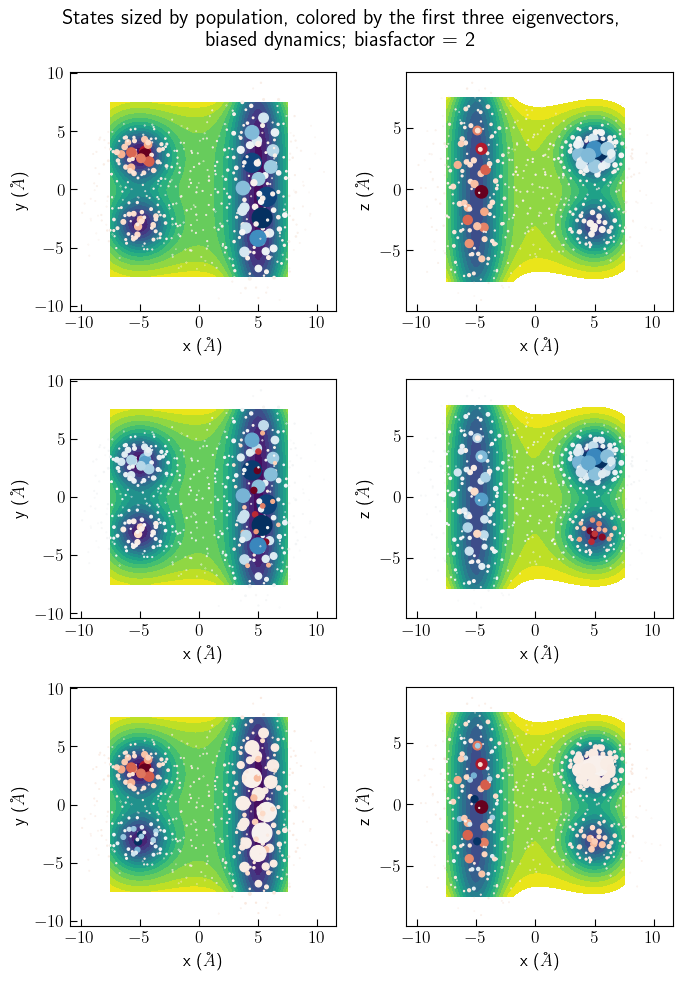

In [52]:
msm = MarkovStateModel(lag_time=1000, n_timescales=3, verbose=False)
msm.fit(ktrajs)
scale = 200 / np.max(msm.populations_)
add_a_bit = 5

fig, axs = plt.subplots(3,2,figsize=(7,10))
axs = axs.flatten()

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2].set_xlabel(r"x ($\AA$)")
    axs[i*2].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2+1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2+1].set_xlabel(r"x ($\AA$)")
    axs[i*2+1].set_ylabel(r"z ($\AA$)")

for i in range(3):
    for j in range(2):
        axs[i*2+j].scatter(kmeans.cluster_centers_[msm.state_labels_, 0],
                           kmeans.cluster_centers_[msm.state_labels_, 1+j],
                           s=scale * msm.populations_,
                           c=msm.left_eigenvectors_[:, i+1],
                           cmap='RdBu')

fig.suptitle("States sized by population, colored by the first three eigenvectors,\n"\
              "biased dynamics; biasfactor = 2")
fig.tight_layout()
print(msm.summarize())

Optimization terminated successfully.
         Current function value: -3.880660
         Iterations: 19
         Function evaluations: 112
Markov state model
------------------
Lag time         : 1000
Reversible type  : mle
Ergodic cutoff   : on
Prior counts     : 0

Number of states : 4
Number of nonzero entries in counts matrix : 16 (100.0%)
Nonzero counts matrix entries:
    Min.   : 1.6
    1st Qu.: 3.3
    Median : 8.5
    Mean   : 312.4
    3rd Qu.: 99.5
    Max.   : 3006.2

Total transition counts :
    4999.001 counts
Total transition counts / lag_time:
    4.999001 units
Timescales:
    [82825.03, 21622.65, 15564.27]  units



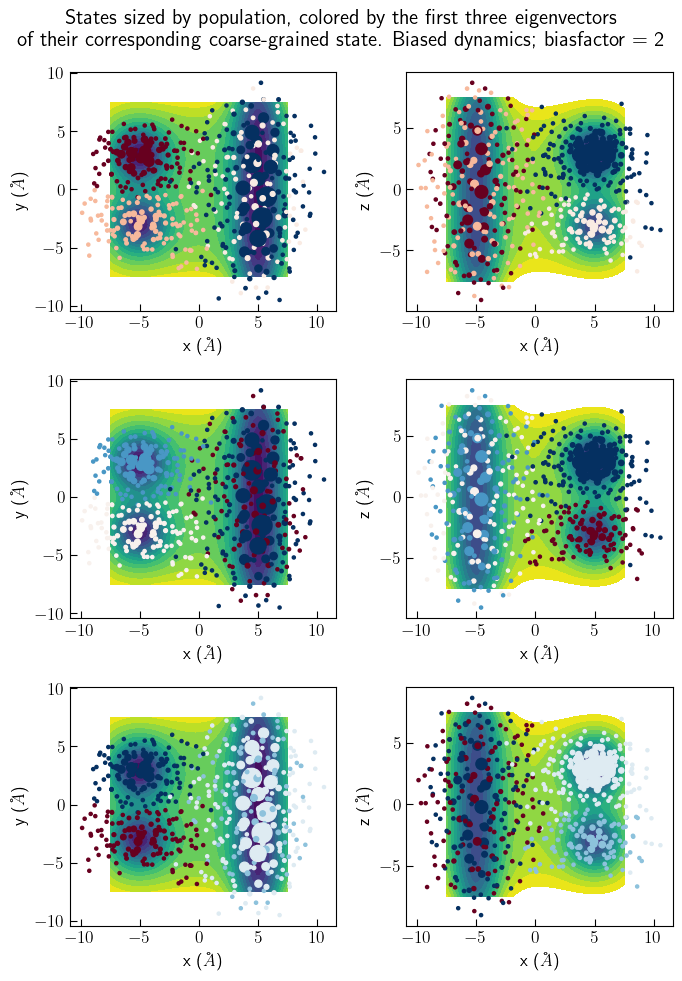

In [53]:
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(ktrajs)
CGmsm = MarkovStateModel(lag_time=1000, n_timescales=3, verbose=False)
CGmsm.fit(macro_trajs)

fig, axs = plt.subplots(3,2,figsize=(7,10))
axs = axs.flatten()

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2].set_xlabel(r"x ($\AA$)")
    axs[i*2].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2+1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2+1].set_xlabel(r"x ($\AA$)")
    axs[i*2+1].set_ylabel(r"z ($\AA$)")

for i in range(3):
    for j in range(2):
        axs[i*2+j].scatter(kmeans.cluster_centers_[msm.state_labels_, 0],
                           kmeans.cluster_centers_[msm.state_labels_, 1+j],
                           s=scale * msm.populations_ + add_a_bit,
                           c=[CGmsm.left_eigenvectors_[:, i+1][k] for k in pcca.microstate_mapping_],
                           cmap='RdBu')
        
fig.suptitle("States sized by population, colored by the first three eigenvectors\n"\
              "of their corresponding coarse-grained state. Biased dynamics; biasfactor = 2")

fig.tight_layout()
print(CGmsm.summarize())

In [54]:
print("Populations according to microstates: ", [sum(msm.populations_[pcca.microstate_mapping_== i]) for i in range(4)])
print("Populations according to macrostates: ", CGmsm.populations_)

Populations according to microstates:  [0.07336100657587417, 0.0754357897065682, 0.22587735230231157, 0.6253258514152459]
Populations according to macrostates:  [0.07318402 0.07695112 0.22967618 0.62018868]


The timescales, using a lag time of 10 picoseconds, are ~987, ~222 and ~167 picoseconds. Similar timescales are obtained from the coarse grained model.

Now I reweight the transitions using DHAM. I use Equations 21-22 from:

Rosta, Edina, and Gerhard Hummer. "Free energies from dynamic weighted histogram analysis using unbiased Markov state model." Journal of chemical theory and computation 11.1 (2015): 276-285.

In [13]:
traj_bias = np.loadtxt(f"biased2x/CVR",skiprows=1)[:,-1]

traj_dict = {tuple(row): bias for row, bias in zip(traj, traj_bias)}
bias = np.array([traj_dict[tuple(row)] for row in kmeans.cluster_centers_])

[19848.04953763   271.19458484   241.75984911]
[20258.12762793   270.6599293    248.99076836]
[20412.54245819   286.56825532   255.48991272]
[21282.0606012    302.56437139   266.96980259]
[22088.3373986    342.4575128    327.84511533]
[25427.44899793   428.68591608   412.29319364]
[24512.51695011   490.2735061    448.26602797]
[17528.89558516   503.82644171   478.99458035]
[6836.23518527  435.50844079  379.44543264]
[2249.77078727  327.28431476  279.54922723]


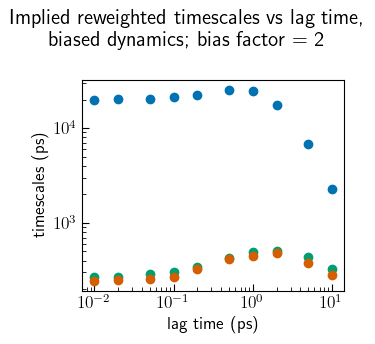

In [14]:
timescales = []
lagtimes = [1,2,5,10,20,50,100,200,500,1000]
ktraj = ktrajs[0]
for lagtime in lagtimes:
    T = np.zeros((size, size), dtype=int)

    for t in range(len(traj) - lagtime):
        i = ktraj[t]         # origin bin at time t
        j = ktraj[t + lagtime]   # destination bin at time t + lag
        T[j, i] += 1        # Note: T[j, i] (column = from, row = to)
    M = np.zeros((size, size))
    for i in range(size):

        for j in range(size):
            if ktraj[ktraj == i].size > 0:
                delta_bias = bias[j] - bias[i]
                weight = np.exp(delta_bias / (5))
                M[i, j] = T[i, j] * weight / len(ktraj[ktraj == i])
    # Normalize rows to make a transition probability matrix
    for i in range(size):
        if M[i, :].sum() > 0:
            M[i, :] /= M[i, :].sum()
    u, lv, rv = _solve_msm_eigensystem(M,4)
    with np.errstate(invalid='ignore', divide='ignore'):
        timescales.append(- lagtime / np.log(u[1:]) / 100)
    print(timescales[-1])

fig, ax = plt.subplots(figsize=(3.5,3.5))

ax.plot(np.array(lagtimes)/100,timescales,"o")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("lag time (ps)")
ax.set_ylabel("timescales (ps)")

fig.suptitle("Implied reweighted timescales vs lag time,\n biased dynamics; bias factor = 2")

fig.tight_layout()

In [16]:
lagtime = 100
T = np.zeros((size, size), dtype=int)

for t in range(len(traj) - lagtime):
    i = ktraj[t]         
    j = ktraj[t + lagtime]  
    T[j, i] += 1
M = np.zeros((size, size))
for i in range(size):
    for j in range(size):
        if ktraj[ktraj == i].size > 0:
            delta_bias = bias[j] - bias[i]
            weight = np.exp(delta_bias / (5))
            M[i, j] = T[i, j] * weight / len(ktraj[ktraj == i])
# Normalize rows to make a transition probability matrix
for i in range(size):
    if M[i, :].sum() > 0:
        M[i, :] /= M[i, :].sum()
u, lv, rv = _solve_msm_eigensystem(M,4)

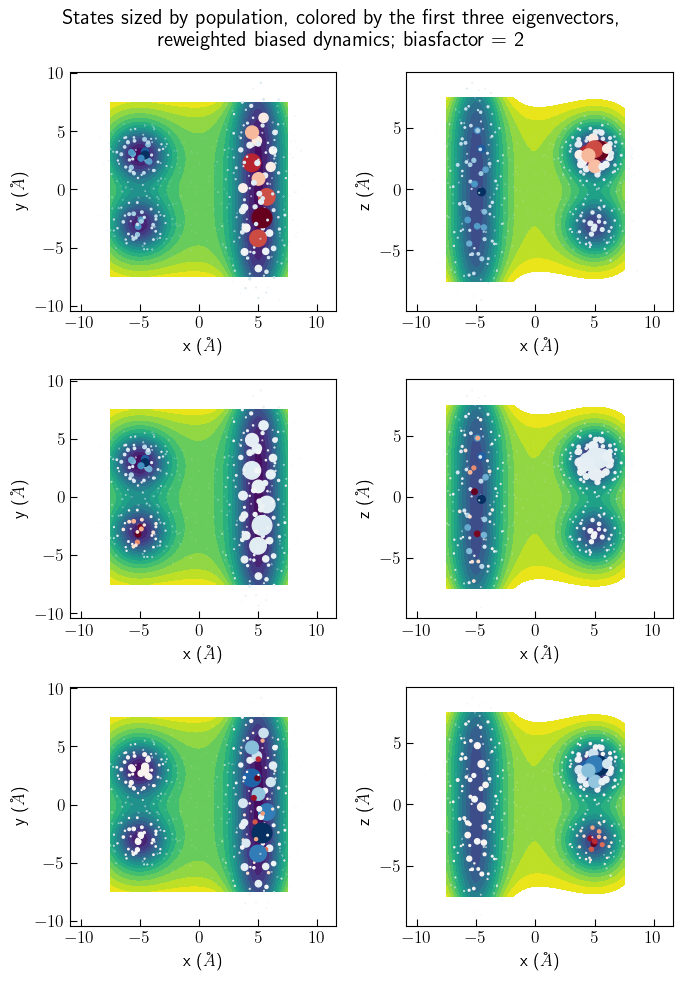

In [17]:
scale = 200 / np.max(lv[:,0])
add_a_bit = 5

fig, axs = plt.subplots(3,2,figsize=(7,10))
axs = axs.flatten()

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2].set_xlabel(r"x ($\AA$)")
    axs[i*2].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2+1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2+1].set_xlabel(r"x ($\AA$)")
    axs[i*2+1].set_ylabel(r"z ($\AA$)")

for i in range(3):
    for j in range(2):
        axs[i*2+j].scatter(kmeans.cluster_centers_[msm.state_labels_, 0],
                           kmeans.cluster_centers_[msm.state_labels_, 1+j],
                           s=scale * lv[:,0],
                           c=lv[:, i+1],
                           cmap='RdBu')

fig.suptitle("States sized by population, colored by the first three eigenvectors,\n"\
              "reweighted biased dynamics; biasfactor = 2")
fig.tight_layout()

Optimization terminated successfully.
         Current function value: -3.982614
         Iterations: 11
         Function evaluations: 101


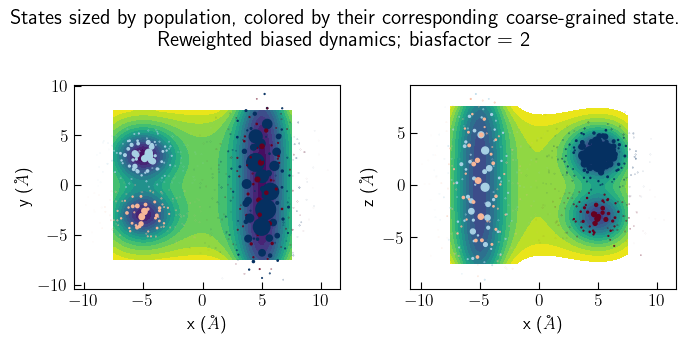

In [18]:
msm.transmat_ = M
msm.lag_time = lagtime
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(ktrajs)

fig, axs = plt.subplots(1,2,figsize=(7,3.5))

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
axs[0].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
axs[0].set_xlabel(r"x ($\AA$)")
axs[0].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
axs[1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
axs[1].set_xlabel(r"x ($\AA$)")
axs[1].set_ylabel(r"z ($\AA$)")

for j in range(2):
    axs[j].scatter(kmeans.cluster_centers_[msm.state_labels_, 0],
                       kmeans.cluster_centers_[msm.state_labels_, 1+j],
                       s=scale * lv[:,0],
                       c=pcca.microstate_mapping_,
                       cmap='RdBu')
    
fig.suptitle("States sized by population, colored by their corresponding coarse-grained state.\n"\
             "Reweighted biased dynamics; biasfactor = 2")

fig.tight_layout()

Text(0.5, 1.0, 'Equilibrium populations')

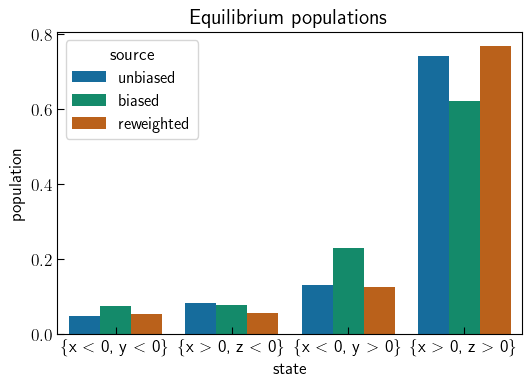

In [39]:
pops = pd.DataFrame({"source": ["unbiased","unbiased","unbiased","unbiased",
                                "biased","biased","biased","biased",
                                "reweighted","reweighted","reweighted","reweighted"],
                     "population":[0.04776605, 0.08184504, 0.13070742, 0.7396815] + list(CGmsm.populations_) + 
                     [sum(lv[:,0][pcca.microstate_mapping_== i]) for i in range(4)],
                     "state":[1,2,3,4,1,2,3,4,1,2,3,4]})
sns.barplot(data=pops,x="state",y="population",hue="source")
plt.xticks(ticks=[0,1,2,3],labels=[r"\{x $<$ 0, y $<$ 0\}", r"\{x $>$ 0, z $<$ 0\}", 
                                   r"\{x $<$ 0, y $>$ 0\}", r"\{x $>$ 0, z $>$ 0\}"])
plt.title("Equilibrium populations")

The reweighted timescales are ~25.5, ~0.5, ~0.4 nanoseconds. All are underestimated, but the longest timescale is on the correct order of magnitude. The reweighted equilibrium populations are pretty consistent with the unbiased ones.

I now repeated all the process for a 50 nanosecond simulation with a higher bias factor of 5.

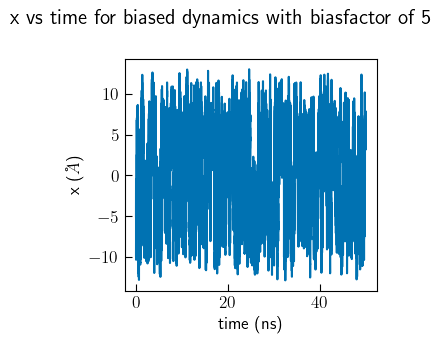

In [40]:
traj = np.loadtxt(f"biased5x/CVR",skiprows=1)
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax.plot(traj[:,0] / 1000, traj[:,1] * 10)
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"x ($\AA$)")

fig.suptitle("x vs time for biased dynamics with biasfactor of 5")

fig.tight_layout()

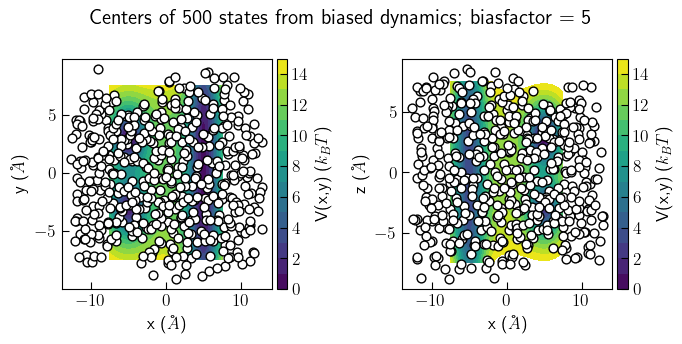

In [55]:
dim = 3 
np.random.seed(21349)
traj = np.loadtxt(f"biased5x/CVR",skiprows=1)[:,1:-1] * 10
size = 500
kmeans = KCenters(n_clusters=size)
kmeans.fit([traj[:, :dim]])

fig, axs = plt.subplots(1,2,figsize=(7,3.5))

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
im = axs[0].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[0].scatter(kmeans.cluster_centers_[:, 0],
                    kmeans.cluster_centers_[:, 1],
                    s=40, color = "white", edgecolor="black")
axs[0].set_xlabel(r"x ($\AA$)")
axs[0].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
im = axs[1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[1].scatter(kmeans.cluster_centers_[:, 0],
           kmeans.cluster_centers_[:, 2],
           s=40, color = "white" ,edgecolor="black")

axs[1].set_xlabel(r"x ($\AA$)")
axs[1].set_ylabel(r"z ($\AA$)")

fig.suptitle("Centers of 500 states from biased dynamics; biasfactor = 5")

fig.tight_layout()

1
2
5
10
20
50
100
200
500
1000
2000
5000
10000


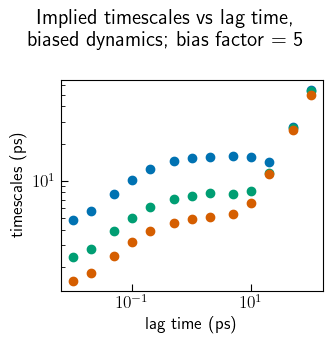

In [56]:
ktrajs = kmeans.predict([traj.copy()])
timescales = []
lagtimes = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000]
for lagtime in lagtimes:
    msm = MarkovStateModel(lag_time=lagtime, n_timescales=3, verbose=False)
    msm.fit(ktrajs)
    timescales.append(msm.timescales_/100)
    print(lagtime)

fig, ax = plt.subplots(figsize=(3.5,3.5))

ax.plot(np.array(lagtimes)/100,timescales,"o")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("lag time (ps)")
ax.set_ylabel("timescales (ps)")

fig.suptitle("Implied timescales vs lag time,\n biased dynamics; bias factor = 5")

fig.tight_layout()

Markov state model
------------------
Lag time         : 200
Reversible type  : mle
Ergodic cutoff   : on
Prior counts     : 0

Number of states : 500
Number of nonzero entries in counts matrix : 30289 (12.1156%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.0
    Median : 0.0
    Mean   : 0.1
    3rd Qu.: 0.1
    Max.   : 15.3

Total transition counts :
    2499.0049999999997 counts
Total transition counts / lag_time:
    12.495024999999998 units
Timescales:
    [1565.59, 786.26, 503.06]  units



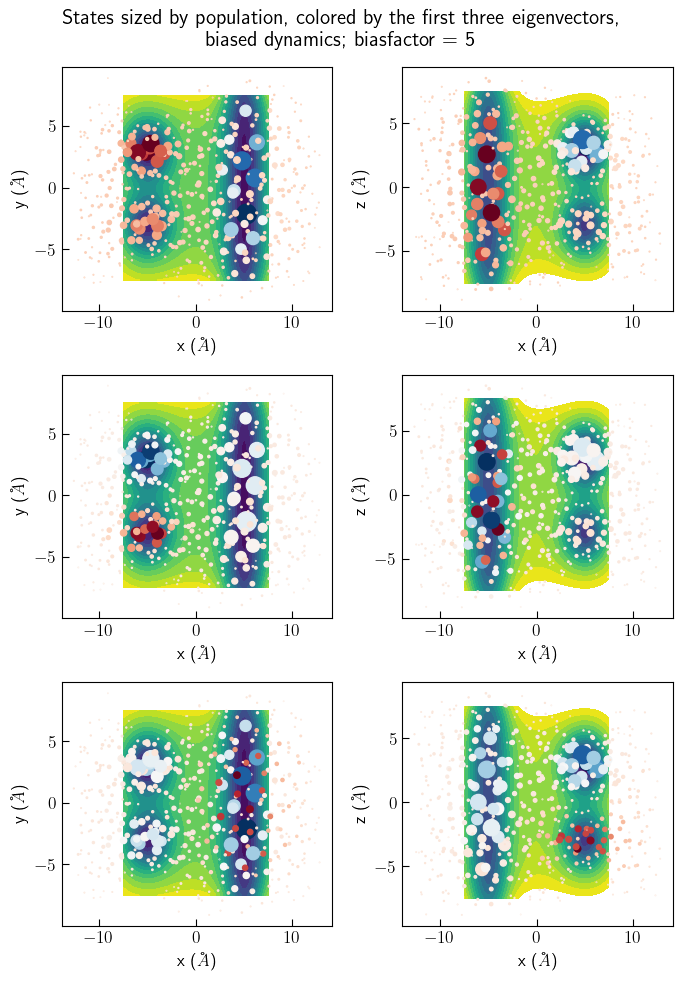

In [57]:
msm = MarkovStateModel(lag_time=200, n_timescales=3, verbose=False)
msm.fit(ktrajs)
scale = 200 / np.max(msm.populations_)
add_a_bit = 5

fig, axs = plt.subplots(3,2,figsize=(7,10))
axs = axs.flatten()

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2].set_xlabel(r"x ($\AA$)")
    axs[i*2].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2+1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2+1].set_xlabel(r"x ($\AA$)")
    axs[i*2+1].set_ylabel(r"z ($\AA$)")

for i in range(3):
    for j in range(2):
        axs[i*2+j].scatter(kmeans.cluster_centers_[msm.state_labels_, 0],
                           kmeans.cluster_centers_[msm.state_labels_, 1+j],
                           s=scale * msm.populations_,
                           c=msm.left_eigenvectors_[:, i+1],
                           cmap='RdBu')

fig.suptitle("States sized by population, colored by the first three eigenvectors,\n"\
              "biased dynamics; biasfactor = 5")

fig.tight_layout()
print(msm.summarize())

Optimization terminated successfully.
         Current function value: -3.196779
         Iterations: 58
         Function evaluations: 161
Markov state model
------------------
Lag time         : 1000
Reversible type  : mle
Ergodic cutoff   : on
Prior counts     : 0

Number of states : 4
Number of nonzero entries in counts matrix : 16 (100.0%)
Nonzero counts matrix entries:
    Min.   : 5.2
    1st Qu.: 13.3
    Median : 21.3
    Mean   : 31.2
    3rd Qu.: 29.4
    Max.   : 126.3

Total transition counts :
    499.001 counts
Total transition counts / lag_time:
    0.499001 units
Timescales:
    [1422.42, 735.26, 509.90]  units

Populations according to microstates:  [0.1054234755985286, 0.2054218450059105, 0.3026901876284457, 0.3864644917671152]
Populations according to macrostates:  [0.10557899 0.20580662 0.30244147 0.38617292]


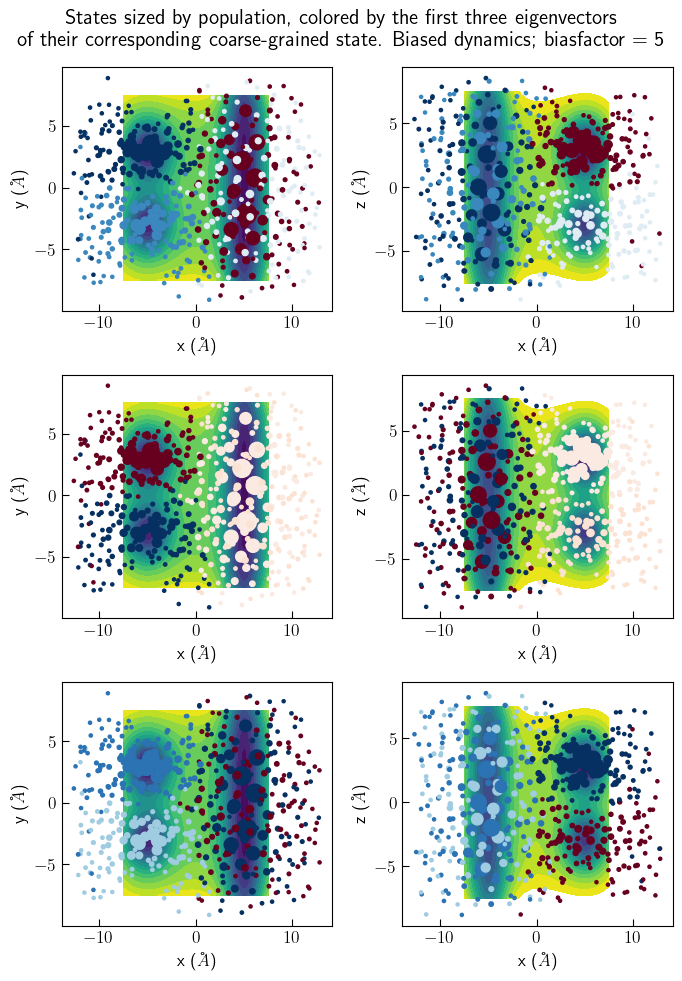

In [59]:
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(ktrajs)
CGmsm = MarkovStateModel(lag_time=1000, n_timescales=3, verbose=False)
CGmsm.fit(macro_trajs)

fig, axs = plt.subplots(3,2,figsize=(7,10))
axs = axs.flatten()

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2].set_xlabel(r"x ($\AA$)")
    axs[i*2].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2+1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2+1].set_xlabel(r"x ($\AA$)")
    axs[i*2+1].set_ylabel(r"z ($\AA$)")

for i in range(3):
    for j in range(2):
        axs[i*2+j].scatter(kmeans.cluster_centers_[msm.state_labels_, 0],
                           kmeans.cluster_centers_[msm.state_labels_, 1+j],
                           s=scale * msm.populations_ + add_a_bit,
                           c=[CGmsm.left_eigenvectors_[:, i+1][k] for k in pcca.microstate_mapping_],
                           cmap='RdBu')
        
fig.suptitle("States sized by population, colored by the first three eigenvectors\n"\
              "of their corresponding coarse-grained state. Biased dynamics; biasfactor = 5")        

fig.tight_layout()
print(CGmsm.summarize())
print("Populations according to microstates: ", [sum(msm.populations_[pcca.microstate_mapping_== i]) for i in range(4)])
print("Populations according to macrostates: ", CGmsm.populations_)

For the biased system, the timescales are 5-15 picosecnods and the states are far more uniformly populated.

In [60]:
traj_bias = np.loadtxt(f"biased5x/CVR",skiprows=1)[:,-1]

traj_dict = {tuple(row): bias for row, bias in zip(traj, traj_bias)}
bias = np.array([traj_dict[tuple(row)] for row in kmeans.cluster_centers_])

[1237.05319024   33.1181282    19.02159737]
[1362.88227906   37.60612898   20.03607319]
[1687.95153005   48.329368     25.97784201]
[1581.40298332   57.84720694   27.68010787]
[1015.15473748   63.21350177   30.90874823]
[250.96894466  36.20215017  20.73907409]
[71.2132564  17.4837546  12.26229093]
[29.01956955 10.49035296  7.05988741]


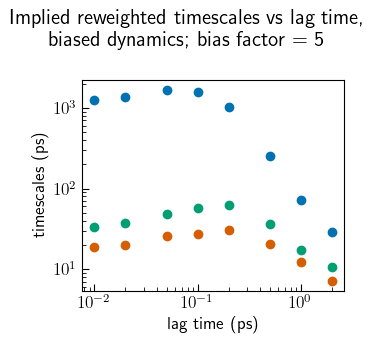

In [61]:
timescales = []
lagtimes = [1,2,5,10,20,50,100,200]
ktraj = ktrajs[0]
for lagtime in lagtimes:
    T = np.zeros((size, size), dtype=int)

    for t in range(len(traj) - lagtime):
        i = ktraj[t] 
        j = ktraj[t + lagtime]   
        T[j, i] += 1
    M = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if ktraj[ktraj == i].size > 0:
                delta_bias = bias[j] - bias[i]
                weight = np.exp(delta_bias / (5))
                M[i, j] = T[i, j] * weight / len(ktraj[ktraj == i])
    # Normalize rows to make a transition probability matrix
    for i in range(size):
        if M[i, :].sum() > 0:
            M[i, :] /= M[i, :].sum()
    u, lv, rv = _solve_msm_eigensystem(M,4)
    with np.errstate(invalid='ignore', divide='ignore'):
        timescales.append(- lagtime / np.log(u[1:]) / 100)
    print(timescales[-1])

fig, ax = plt.subplots(figsize=(3.5,3.5))

ax.plot(np.array(lagtimes)/100,timescales,"o")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("lag time (ps)")
ax.set_ylabel("timescales (ps)")

fig.suptitle("Implied reweighted timescales vs lag time,\n biased dynamics; bias factor = 5")

fig.tight_layout()

In [62]:
lagtime = 10
T = np.zeros((size, size), dtype=int)

for t in range(len(traj) - lagtime):
    i = ktraj[t]      
    j = ktraj[t + lagtime]  
    T[j, i] += 1       
M = np.zeros((size, size))
for i in range(size):

    for j in range(size):
        if ktraj[ktraj == i].size > 0:
            delta_bias = bias[j] - bias[i]
            weight = np.exp(delta_bias / (5))
            M[i, j] = T[i, j] * weight / len(ktraj[ktraj == i])
# Normalize rows to make a transition probability matrix
for i in range(size):
    if M[i, :].sum() > 0:
        M[i, :] /= M[i, :].sum()
u, lv, rv = _solve_msm_eigensystem(M,4)

array([1581.40298332,   57.84720694,   27.68010787])

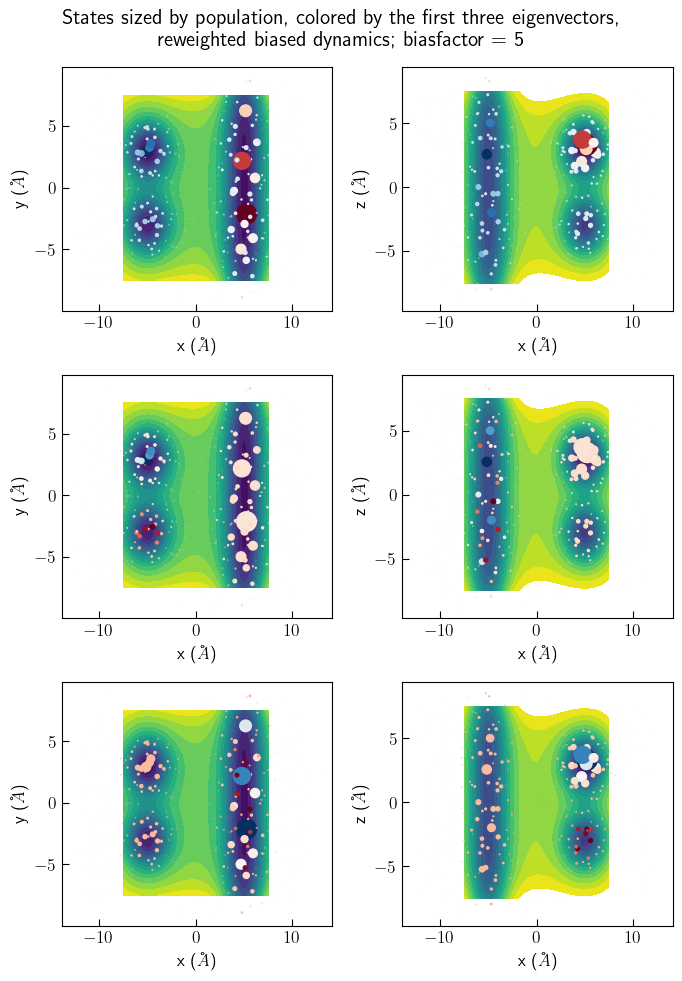

In [63]:
scale = 200 / np.max(lv[:,0])
add_a_bit = 5

fig, axs = plt.subplots(3,2,figsize=(7,10))
axs = axs.flatten()

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2].set_xlabel(r"x ($\AA$)")
    axs[i*2].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
for i in range(3):
    axs[i*2+1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
    axs[i*2+1].set_xlabel(r"x ($\AA$)")
    axs[i*2+1].set_ylabel(r"z ($\AA$)")

for i in range(3):
    for j in range(2):
        axs[i*2+j].scatter(kmeans.cluster_centers_[msm.state_labels_, 0],
                           kmeans.cluster_centers_[msm.state_labels_, 1+j],
                           s=scale * lv[:,0],
                           c=lv[:, i+1],
                           cmap='RdBu')
fig.suptitle("States sized by population, colored by the first three eigenvectors,\n"\
              "reweighted biased dynamics; biasfactor = 5")
fig.tight_layout()
- lagtime / np.log(u[1:]) / 100

Optimization terminated successfully.
         Current function value: -3.898103
         Iterations: 19
         Function evaluations: 129


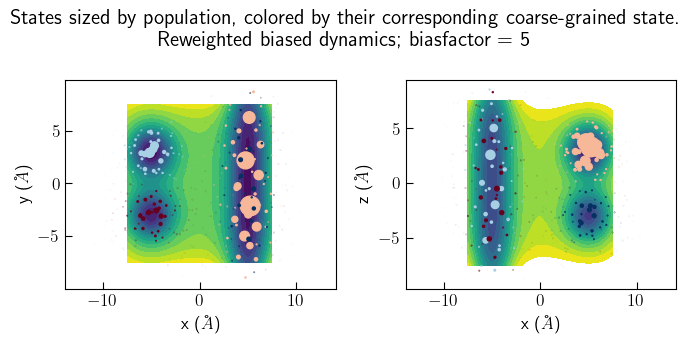

In [64]:
msm.transmat_ = M
msm.lag_time = lagtime
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(ktrajs)

fig, axs = plt.subplots(1,2,figsize=(7,3.5))

surface2 = surface.groupby(["x","y"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
axs[0].tricontourf(surface2.x,surface2.y,surface2.V,levels=np.linspace(0,15,16))
axs[0].set_xlabel(r"x ($\AA$)")
axs[0].set_ylabel(r"y ($\AA$)")

surface2 = surface.groupby(["x","z"]).sum("H").reset_index()
surface2.H = surface2.H/surface2.H.sum()
surface2.V = -np.log(surface2.H)
surface2.V -= surface2.V.min()
axs[1].tricontourf(surface2.x,surface2.z,surface2.V,levels=np.linspace(0,15,16))
axs[1].set_xlabel(r"x ($\AA$)")
axs[1].set_ylabel(r"z ($\AA$)")

for j in range(2):
    axs[j].scatter(kmeans.cluster_centers_[msm.state_labels_, 0],
                       kmeans.cluster_centers_[msm.state_labels_, 1+j],
                       s=scale * lv[:,0],
                       c=pcca.microstate_mapping_,
                       cmap='RdBu')
fig.suptitle("States sized by population, colored by their corresponding coarse-grained state.\n"\
             "Reweighted biased dynamics; biasfactor = 5")
fig.tight_layout()

Text(0.5, 1.0, 'Equilibrium populations')

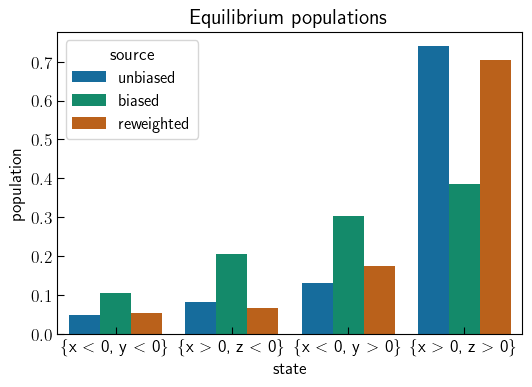

In [71]:
pops = pd.DataFrame({"source": ["unbiased","unbiased","unbiased","unbiased",
                                "biased","biased","biased","biased",
                                "reweighted","reweighted","reweighted","reweighted"],
                     "population":[0.04776605, 0.08184504, 0.13070742, 0.7396815] + list(CGmsm.populations_) + 
                     list(np.sort([sum(lv[:,0][pcca.microstate_mapping_== i]) for i in range(4)])),
                     "state":[1,2,3,4,1,2,3,4,1,2,3,4]})
sns.barplot(data=pops,x="state",y="population",hue="source")
plt.xticks(ticks=[0,1,2,3],labels=[r"\{x $<$ 0, y $<$ 0\}", r"\{x $>$ 0, z $<$ 0\}", 
                                   r"\{x $<$ 0, y $>$ 0\}", r"\{x $>$ 0, z $>$ 0\}"])
plt.title("Equilibrium populations")

With this bias factor, the timescales are off by 2 orders of magnitude, but the populations are pretty good.